In [66]:
from matplotlib.patches import Ellipse
import tensorflow as tf
import tensorflow_probability as tfp
from keras.models import Sequential, Model
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Activation, Dense, Flatten,Reshape
tfd = tfp.distributions
from keras.models import Sequential 
from tensorflow.keras.models import Sequential, Model

from keras import models
tfb = tfp.bijectors
tfpl = tfp.layers
tfb = tfp.bijectors
model= tf.keras.Sequential()
import numpy as np
import matplotlib.pyplot as plt 
print("TF version:", tf.__version__)
print("TFP version:", tfp.__version__)



TF version: 2.6.0
TFP version: 0.14.0


In [54]:
(x_train, _), (x_test,_) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255
example_x = x_test[:16]


In [55]:
batch_size = 64
x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)



# Define Encoding Distribution

In [56]:
latent_size = 2
event_shape = (28,28)

In [57]:
encoder = Sequential([
    Flatten(input_shape = event_shape),
    Dense(256, activation = "relu"),
    Dense(128, activation = "relu"),
    Dense(64, activation = "relu"),
    Dense(32, activation = "relu"),
    Dense(2*latent_size),
    tfpl.DistributionLambda(
        lambda t: tfd.MultivariateNormalDiag(
            loc = t[...,:latent_size],
            scale_diag=tf.math.exp(t[...,latent_size:])
        )
    )
    
])

# Check the encoder works

In [58]:
encoder(example_x)

<tfp.distributions._TensorCoercible 'sequential_14_distribution_lambda_4_tensor_coercible' batch_shape=[16] event_shape=[2] dtype=float32>

In [59]:
decoder = Sequential([
    Dense(32, activation = "relu"),
    Dense(64, activation = "relu"),
    Dense(128, activation = "relu"),
    Dense(256, activation = "relu"),
    Dense(tfpl.IndependentBernoulli.params_size(event_shape)),
    tfpl.IndependentBernoulli(event_shape)

])

# Check if Decoder works

In [60]:
decoder(tf.random.normal([16,latent_size]))

<tfp.distributions._TensorCoercible 'sequential_15_independent_bernoulli_3_tensor_coercible' batch_shape=[16] event_shape=[28, 28] dtype=float32>

# define the prior

In [61]:
prior = tfd.MultivariateNormalDiag(loc = tf.zeros(latent_size))

prior

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

# loss Function (is the negative ElBO)

In [62]:
def loss(x, encoding_dist, sampled_decoding_dist,prior):
    return tf.reduce_sum(
    tfd.kl_divergence(encoding_dist,prior) - sampled_decoding_dist.log_prob(x))

# get loss and the gradient of the loss

In [63]:
@tf.function
def get_loss_get_grads(x):
    with tf.GradientTape() as tape:
        encoding_dist = encoder(x)
        sampled_z = encoding_dist.sample()
        sampled_deconding_dist = decoder(sampled_z)
        current_loss = loss(x, encoding_dist, sampled_deconding_dist,prior)
    grads = tape.gradient(current_loss, 
                          encoder.trainable_variables + 
                          decoder.trainables)
    
    return current_loss, grads
    

# Compile and train model

In [ ]:
num_epoch = 5

opt = tf.keras.optimizers.Adam()
for i in range(num_epoch):
    for train_batch in x_train:
        current_loss, grads = get_loss_get_grads(train_batch)
        opt.apply_gradients(zip(grads, encoder.trainable_variables + 
                          decoder.trainables))
        
    print("-Elbo after epoch {}: {:.0f}".format(i+1, current_loss.numpy()))

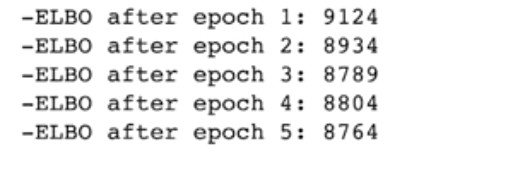

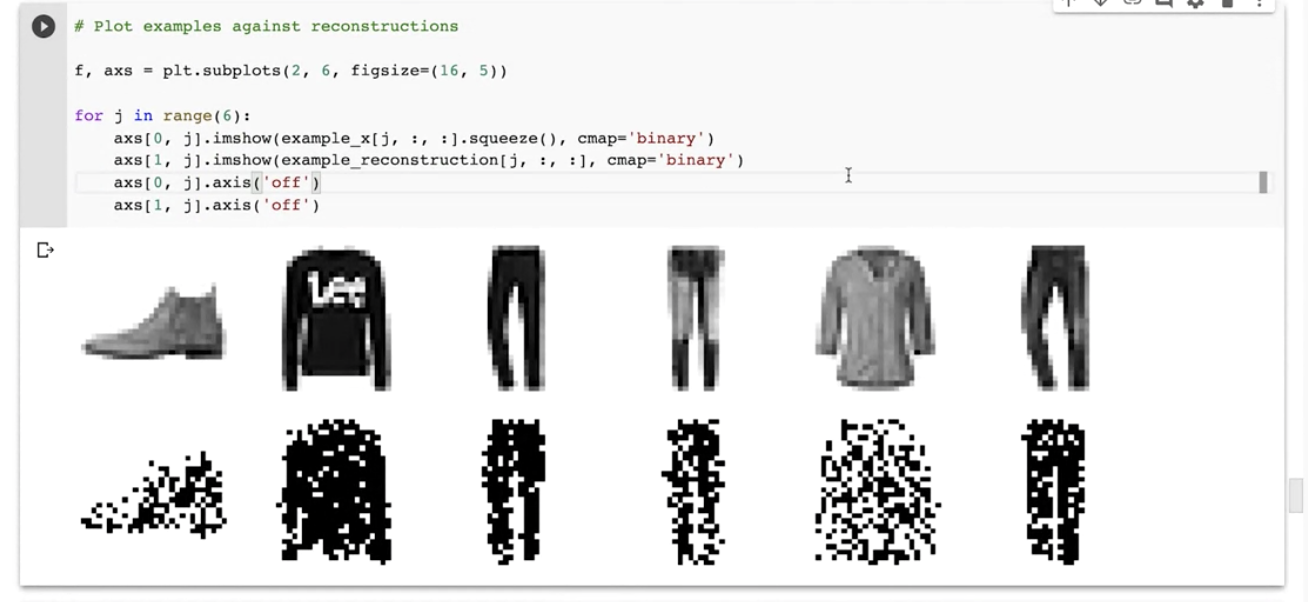